<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00


In [7]:
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

# NewsAPI key
newsapi_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

# Broader financial queries related to U.S. Treasury bonds
queries = ['U.S. Treasury', 'Treasury Bonds', 'Bond Market', 'Government Bonds']

# Set up VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Function to get news articles with date range
def get_news(query, api_key, start_date, end_date, num_articles=100):
    url = f'https://newsapi.org/v2/everything?q={query}&from={start_date}&to={end_date}&apiKey={api_key}&language=en&pageSize={num_articles}'
    response = requests.get(url)
    data = response.json()

    if data['status'] != 'ok':
        print(f"Error fetching data for query '{query}': {data.get('message')}")
        return []

    news_data = []
    articles = data.get('articles', [])
    for article in articles:
        news_content = article['description'] if article['description'] else article['content']
        sentiment = get_sentiment(news_content)
        news_data.append([article['source']['name'], query, sentiment, news_content])

    return news_data

# Define your date range
start_date = '2024-08-09'
end_date = '2024-08-08'

# Store all news data
all_news = []

for query in queries:
    all_news.extend(get_news(query, newsapi_key, start_date, end_date))

# Check if any news was retrieved
if not all_news:
    print("No news articles were retrieved. Try broadening your queries or checking the API key.")
else:
    # Create a DataFrame
    df = pd.DataFrame(all_news, columns=['Source', 'Entity', 'Sentiment', 'News Content'])

    # Split the data into training and validation sets
    train, validation = train_test_split(df, test_size=0.2, random_state=42)

    # Save to CSV
    train.to_csv('financial_news_bonds_sentiment_train.csv', index=False)
    validation.to_csv('financial_news_bonds_sentiment_val.csv', index=False)

    # Print the first few rows of the training and validation sets
    print("Training Set:")
    print(train.head())

    print("\nValidation Set:")
    print(validation.head())


Training Set:
                  Source            Entity Sentiment  \
342    Economictimes.com  Government Bonds  Positive   
202  Yahoo Entertainment       Bond Market  Positive   
75        ETF Daily News     U.S. Treasury  Positive   
84       Coinjournal.net     U.S. Treasury  Positive   
355      Lewrockwell.com  Government Bonds  Positive   

                                          News Content  
342  For mutual fund investors, an unchanged repo r...  
202  Asian shares are ending a rough week on a high...  
75   Kingswood Wealth Advisors LLC acquired a new s...  
84   Franklin Templeton has launched its US governm...  
355  I love women. My head still turns whenever a g...  

Validation Set:
                  Source            Entity Sentiment  \
193             Livemint       Bond Market  Negative   
33                Reason     U.S. Treasury  Negative   
15   Yahoo Entertainment     U.S. Treasury  Positive   
311  Yahoo Entertainment  Government Bonds  Positive   
57        

In [8]:
train = train.dropna(subset=['News Content'])

display(train.isnull().sum())
print("*****"* 5)
display(validation.isnull().sum())

,0
Source,0
Entity,0
Sentiment,0
News Content,0


*************************


,0
Source,0
Entity,0
Sentiment,0
News Content,0


In [9]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

In [10]:
# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Combine counts into a single DataFrame
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis=1)

# Fill missing values (if any) with 0
combined_counts.fillna(0, inplace=True)

# Rename columns
combined_counts.columns = ['Test Data', 'Validation Data']  # Set desired column names

combined_counts

,Test Data,Validation Data
Sentiment,,
Positive,160,40
Negative,88,20
Neutral,35,14


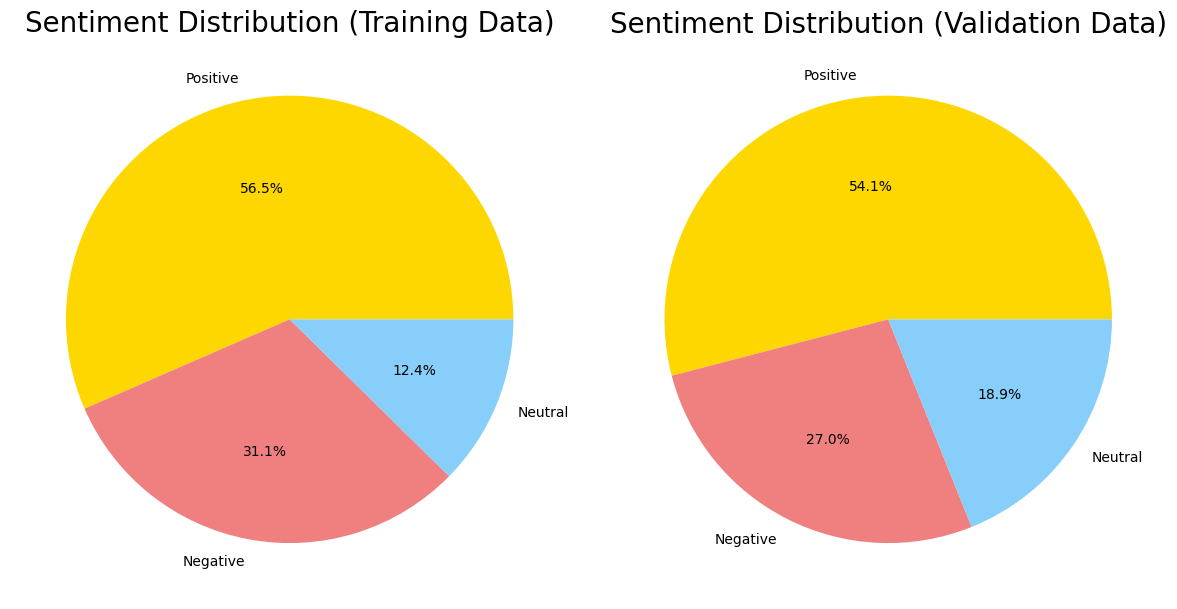

In [11]:
import matplotlib.pyplot as plt

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for better view

# Create pie chart for training data
ax1.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=20)

# Create pie chart for validation data
ax2.pie(sentiment_counts_validation, labels=sentiment_counts_validation.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [12]:
# Calculate the value counts of 'Entity'
entity_counts = train['Entity'].value_counts()

# Get the top 9 names
top_names = entity_counts.head(19)

# Aggregate the tenth name as 'Other'
other_count = entity_counts[19:].sum()
top_names['Other'] = other_count

# Display the top 19 names and 'Other'
top_names.to_frame()

,count
Entity,
Bond Market,80
Government Bonds,77
U.S. Treasury,69
Treasury Bonds,57
Other,0


In [13]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Calculate the percentages
percentages = (top_names / top_names.sum()) * 100

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=percentages.index,
    values=percentages,
    textinfo='label+percent',
    insidetextorientation='radial'
)])


# Update layout
fig.update_layout(
    title_text='Top Names with Percentages',
    showlegend=False
)

# Show the plot
fig.show()

In [14]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [15]:
import pandas as pd
import plotly.graph_objects as go

# Assuming you've already run the data preprocessing steps
data = train[['News Content', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Use the entire training data as data_train
data_train = data

# Use validation data as data_test
data_test = validation[['News Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_train.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_train[k].tolist()[:10] for k in data_train.columns],
        fill_color=[
            'lightcyan',  # News Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 10 Rows of Training Data',
    width=1000,
    height=500,
)

fig.show()


<ipython-input-15-086cddd329a0>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-086cddd329a0>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-086cddd329a0>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-086cd

In [16]:
import plotly.graph_objects as go

# Create a colorful table using Plotly for the test data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_test[k].tolist()[:5] for k in data_test.columns],  # Show first 5 rows
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment
              ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 5 Rows of Test Data',
    width=1000,
    height=500,
)

# Show the figure
fig.show()

# If you want to save the figure as an HTML file, uncomment the following line:
# fig.write_html("test_data_sample.html")


In [17]:
%%time

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the dataF
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3})
    return df['News Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model_BERT
model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT.to(device)

# Set up optimizer
optimizer = AdamW(model_BERT.parameters(), lr=2e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model_BERT.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_BERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model_BERT.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_BERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')


torch.save(model_BERT.state_dict(), 'sentiment_model_BERT.pth')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epoch 1/3, Test Accuracy: 0.5405
Epoch 2/3, Test Accuracy: 0.5946
Epoch 3/3, Test Accuracy: 0.7162
CPU times: user 20min 16s, sys: 15.5 s, total: 20min 31s
Wall time: 20min 52s


In [22]:
# Final evaluation

print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.75      0.60      0.67        20
     Neutral       1.00      0.21      0.35        14
    Positive       0.69      0.95      0.80        40

    accuracy                           0.72        74
   macro avg       0.81      0.59      0.61        74
weighted avg       0.77      0.72      0.68        74



In [25]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix BERT \n")
confusion_matrix_BERT

Confusion matrix BERT 



array([[12,  0,  8],
       [ 2,  3,  9],
       [ 2,  0, 38]])

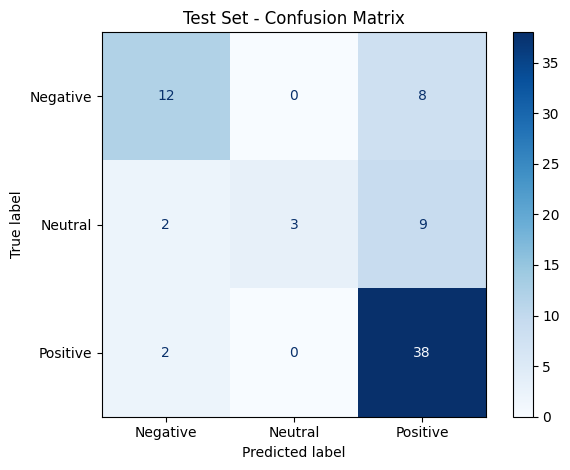

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()